# Week 7 - Vector Space Word Embeddings

By Chu Zhuang

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

# Getting our corpora


For this homework analysis, we continue our 'Thank you Because' project analysis (a conversation technique to help negotaite difference, which have two conditions: TYB-thank you because manipulation, and NB-No because condition) and the conversation corpora (46 pair now, each about 500words).

In this homework, we not only care about the words that each pair or each subject said, but also the words they said in each turn of conversation. so we put more efforts in organizing data in this homework:

In [2]:
#Load the data
import re

text_file='TYB_info.txt'
with open(text_file, encoding='utf-8') as f:
    lines=f.readlines()
    
pair_id=[]
condition=[]
topic=[]

for line in lines[1:]:
    line_sp=line.split('\t')
    pair_id.append(line_sp[0])
    condition.append(line_sp[1])
    topic.append(re.sub(r'\n','',line_sp[2]))

In [3]:
#version3
file_num=pair_id
num_of_file=len(file_num)
#condition=['NB','TYB','NB','TYB','TYB','NB','NB','TYB','TYB','TYB','NB']
#topic=[11,11,2,2,5,7,7,13,13,11,11]

conversation_txt_all=[]
conversation_txt_A_all=[]
conversation_txt_B_all=[]
conversation_txt_A_all0=[]
conversation_txt_B_all0=[]
round_info_A_all=[]
round_info_B_all=[]
inter_num_A_all=[]
inter_num_B_all=[]
# read each file 
for i in range(num_of_file):
    filename='Transcripts/'+file_num[i]+'_otter.xz.txt'
    with open(filename, encoding='utf-8') as f:
        lines=f.readlines()
    
    conversation_txt=[]
    conversation_txt_A=[]
    conversation_txt_B=[]
    round_A=0
    round_B=0
    round_info_A=[]
    round_info_B=[]
    inter_num_A=[]
    inter_num_B=[]
    conversation_txt_A_in1=[]
    conversation_txt_B_in1=[]
    conversation_txt_A_in0=''
    conversation_txt_B_in0=''
    l_len=len(lines[:-1])
    for i,line in enumerate(lines):
        re_other=r'\[Person (A|B):(.*?)\]'
        re_other2=r'\[Speaker (1|2):(.*?)\]'
        find_other=re.findall(re_other,line)
        find_other2=re.findall(re_other2,line)
        line=re.sub(re_other,'', line)
        line=re.sub(re_other2,'', line)
        conversation_txt_A_in=[]
        conversation_txt_B_in=[]
        inter_A=0
        inter_B=0
        for other in find_other2: #speaker
            other_content=other[1]
            if person_id=='A':
                inter_B+=1
                conversation_txt_B_in.append(other_content)
            elif person_id=='B':
                inter_A+=1
                conversation_txt_A_in.append(other_content)                   

        for other in find_other:
            other_id=other[0]
            other_content=other[1]
            if other_id=='A':
                inter_A+=1
                conversation_txt_A_in.append(other_content)
            elif other_id=='B':
                inter_B+=1
                conversation_txt_B_in.append(other_content)
        
        re_person=r'Person (A|B)'
        find_person=re.search(re_person,line)
        if find_person:
            person_id=find_person.group(1)
        else:
            line=re.sub(r'\n','',line)
            line=re.sub(r'--','',line)
            if line:
                if len(line)<50:
                    if person_id=='A':
                        conversation_txt_A_in0=conversation_txt_A_in0+'. '+line
                    if person_id=='B':
                        conversation_txt_B_in0=conversation_txt_B_in0+'. '+line
                else:
                    conversation_txt.append(line)    
                    conversation_txt_A_in1=conversation_txt_A_in0
                    conversation_txt_B_in1=conversation_txt_B_in0
                    conversation_txt_A_in0='.'.join(conversation_txt_A_in)
                    conversation_txt_B_in0='.'.join(conversation_txt_B_in)    
                    if person_id=='A':
                        round_A+=1
                        round_info_A.append(round_A)
                        inter_num_B.append(inter_B)
                        if len(conversation_txt_A_in1)!=0:
                            line=conversation_txt_A_in1+'. '+line
                        if len(conversation_txt_B_in1)!=0:
                            conversation_txt_B_in0=conversation_txt_B_in1+'. '+conversation_txt_B_in0
                        conversation_txt_A.append(line)
                    elif person_id=='B':
                        round_B+=1
                        round_info_B.append(round_B)
                        inter_num_A.append(inter_A)
                        if len(conversation_txt_B_in1)!=0:
                            line=conversation_txt_B_in1+'. '+line
                        if len(conversation_txt_A_in1)!=0:
                            conversation_txt_A_in0=conversation_txt_A_in1+'. '+conversation_txt_A_in0
                        conversation_txt_B.append(line)
        if i==l_len-1:
            if len(conversation_txt_A_in0)!=0:
                conversation_txt_A.append(conversation_txt_A_in0)
            if len(conversation_txt_B_in0)!=0:
                conversation_txt_B.append(conversation_txt_B_in0)
                
    conversation_txt=' '.join(conversation_txt)       
    conversation_txt_A0=' '.join(conversation_txt_A)    
    conversation_txt_B0=' '.join(conversation_txt_B)    
    
    conversation_txt_all.append(conversation_txt)
    conversation_txt_A_all0.append(conversation_txt_A0)
    conversation_txt_B_all0.append(conversation_txt_B0)
    conversation_txt_A_all.append(conversation_txt_A)
    conversation_txt_B_all.append(conversation_txt_B)
    round_info_A_all.append(round_info_A)
    round_info_B_all.append(round_info_B)
    inter_num_A_all.append(inter_num_A)
    inter_num_B_all.append(inter_num_B)

#organize into a dataframe
df_con2=pandas.DataFrame({'condition':condition,'pair_id':pair_id,'topic':topic,'conversation_txt':conversation_txt_all,'con_txt_A':conversation_txt_A_all0,'con_txt_B':conversation_txt_B_all0,'turn_txt_A':conversation_txt_A_all,'turn_txt_B':conversation_txt_B_all,'round_A':round_info_A_all,'round_B':round_info_B_all,'inter_num_A':inter_num_A_all,'inter_num_B':inter_num_B_all })

Organized in the pair format:

In [56]:
df_con2

,condition,pair_id,topic,conversation_txt,con_txt_A,con_txt_B,turn_txt_A,turn_txt_B,round_A,round_B,inter_num_A,inter_num_B
0,NB,5,10,So uh they said that this is a topic we disagr...,". Okay, so uh, I guess they said we should sta...",". Yea, we should start. . Um, yeah.. I actuall...","[. Okay, so uh, I guess they said we should st...","[. Yea, we should start. . Um, yeah.. I actual...","[1, 2, 3]","[1, 2]","[0, 0]","[0, 0, 0]"
1,TYB,6,2,"So I don't really I think I saidyes, everyone ...","So I don't really I think I saidyes, everyone ...",I-I think put something that's below five.. T...,"[So I don't really I think I saidyes, everyone...",[I-I think put something that's below five.. ...,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5]","[1, 3, 1, 2, 2]","[0, 0, 0, 0, 1, 1]"
2,NB,7,4,"So I, when I read this question I thought abou...","So I, when I read this question I thought abou...","Uh-huh. Uh, so, uh I-I actually uh read a lot...","[So I, when I read this question I thought abo...","[ Uh-huh. Uh, so, uh I-I actually uh read a lo...","[1, 2, 3]","[1, 2, 3, 4]","[0, 0, 0, 0]","[1, 0, 0]"
3,TYB,8,6,I strongly disagree with this I think you sho...,. Okay so youWhat's your opinion on this?. Oh...,I strongly disagree with this I think you sho...,[. Okay so youWhat's your opinion on this?. O...,[I strongly disagree with this I think you sh...,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5, 6]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0, 0]"
4,TYB,9,1,"So I guess like, wha-wha-what do you think abo...",". Okay, let's start, yea [laugh]. . Yeah, so u...",". I'm good whenever you are. So I guess like, ...","[. Okay, let's start, yea [laugh]. . Yeah, so ...","[. I'm good whenever you are. So I guess like,...","[1, 2]","[1, 2, 3, 4]","[0, 3, 0, 0]","[0, 0]"
5,TYB,11,8,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,[I like what you said about like the right to....,[I just strongly believe in the right to um {{...,"[1, 2, 3, 4]","[1, 2, 3, 4, 5, 6, 7]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]"
6,NB,12,11,"Yea, so so so. What do youwhat do you personal...","I think that the US, I answered that the US sh...","Yea, so so so. What do youwhat do you personal...","[I think that the US, I answered that the US s...","[Yea, so so so. What do youwhat do you persona...","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6, 7]","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0]"
7,NB,13,5,"Okay, um, so I put a four. I like very minorly...",. I disagree. . I put I put a 10 for this. . L...,"Okay, um, so I put a four. I like very minorly...",[. I disagree. . I put I put a 10 for this. . ...,"[Okay, um, so I put a four. I like very minorl...","[1, 2, 3]","[1, 2]","[0, 0]","[1, 0, 0]"
8,TYB,14,4,"Umm I said yes umm, but I don't know you can l...","Umm I said yes umm, but I don't know you can l...",. Um OKI said nodid you say yes or no?. . UmmI...,"[Umm I said yes umm, but I don't know you can ...",[. Um OKI said nodid you say yes or no?. . Umm...,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1]"
9,NB,15,13,"Oh, okay, um, so I felt like uhI feel like I r...",". [laughs] Yeah. . Sorry, I can't hear. Yeah, ...","Oh, okay, um, so I felt like uhI feel like I r...","[. [laughs] Yeah. . Sorry, I can't hear. Yeah,...","[Oh, okay, um, so I felt like uhI feel like I ...","[1, 2, 3]","[1, 2, 3, 4, 5, 6, 7]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0]"


Re-organized turns for each subj and each pair: totally we have 441 turns of conversation across 46 pairs.

In [4]:
#For each round 
index_all_A,condition_all_A,pair_all_A,topic_all_A,turn_txt_A_all,round_A_all,inter_A_all=[],[],[],[],[],[],[]
index_all_B,condition_all_B,pair_all_B,topic_all_B,turn_txt_B_all,round_B_all,inter_B_all=[],[],[],[],[],[],[]

for index, row in df_con2.iterrows():
    index0=index
    condition0=row['condition']
    pair0=row['pair_id']
    topic0=row['topic']
    turn_A=len(row['round_A'])
    turn_B=len(row['round_B'])
    
    index_all_A.extend([index0]*turn_A)
    pair_all_A.extend([pair0]*turn_A)
    topic_all_A.extend([topic0]*turn_A)
    condition_all_A.extend([condition0]*turn_A)
    turn_txt_A=row['turn_txt_A']
    turn_txt_A_all.extend(turn_txt_A[:turn_A])
    round_A_all.extend(row['round_A'])
    inter_A=row['inter_num_A']
    if len(inter_A)<turn_A:
        inter_A.extend([0]*(turn_A-len(inter_A)))
    inter_A_all.extend(inter_A[:turn_A])
    
    index_all_B.extend([index0]*turn_B)
    pair_all_B.extend([pair0]*turn_B)
    topic_all_B.extend([topic0]*turn_B)
    condition_all_B.extend([condition0]*turn_B)
    turn_txt_B=row['turn_txt_B']
    turn_txt_B_all.extend(turn_txt_B[:turn_B])
    #turn_txt_B_all.extend(row['turn_txt_B'])
    round_B_all.extend(row['round_B'])
    inter_B=row['inter_num_B']
    if len(inter_B)<turn_B:
        inter_B.extend([0]*(turn_B-len(inter_B)))
    inter_B_all.extend(inter_B[:turn_B])
    #inter_B_all.extend(row['inter_num_B'][:turn_B])
    
df_A=pandas.DataFrame({'index':index_all_A,'condition':condition_all_A,'pair_id':pair_all_A,'topic':topic_all_A,'turn_txt':turn_txt_A_all,'round':round_A_all,'inter_num':inter_A_all})
df_B=pandas.DataFrame({'index':index_all_B,'condition':condition_all_B,'pair_id':pair_all_B,'topic':topic_all_B,'turn_txt':turn_txt_B_all,'round':round_B_all,'inter_num':inter_B_all})

In [5]:
df_A['tokenized_text'] = df_A['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_A['word_counts'] = df_A['tokenized_text'].apply(lambda x: len(x))
df_B['tokenized_text'] = df_B['turn_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_B['word_counts'] = df_B['tokenized_text'].apply(lambda x: len(x))

In [6]:
df_A['agent']=['A']*len(df_A)
df_B['agent']=['B']*len(df_B)

In [7]:
df_AB_turn=pandas.concat([df_A,df_B])
df_AB_turn=df_AB_turn.reset_index(drop=True)
df_AB_turn

,index,condition,pair_id,topic,turn_txt,round,inter_num,tokenized_text,word_counts,agent
0,0,NB,5,10,". Okay, so uh, I guess they said we should sta...",1,0,"[Okay, so, uh, I, guess, they, said, we, shoul...",34,A
1,0,NB,5,10,. Um I guess I'd like to hear you talk about i...,2,0,"[Um, I, guess, I, 'd, like, to, hear, you, tal...",241,A
2,0,NB,5,10,And then the other thing is like from like a m...,3,0,"[And, then, the, other, thing, is, like, from,...",169,A
3,1,TYB,6,2,"So I don't really I think I saidyes, everyone ...",1,1,"[So, I, do, n't, really, I, think, I, saidyes,...",13,A
4,1,TYB,6,2,"Oh really. Okay, uhhm so I-I think the reason...",2,3,"[Oh, really, Okay, uhhm, so, I, I, think, the,...",88,A
...,...,...,...,...,...,...,...,...,...,...
436,45,TYB,62,4,"Yeah. laughs. Yeah, yeah definitely.. Right. ...",3,0,"[Yeah, laughs, Yeah, yeah, definitely, Right, ...",144,B
437,45,TYB,62,4,". Yeah. . Right. . . Right, right. Yeah, exact...",4,0,"[Yeah, Right, Right, right, Yeah, exactly, lau...",46,B
438,45,TYB,62,4,I don't know to what extent race plays like i...,5,0,"[I, do, n't, know, to, what, extent, race, pla...",49,B
439,45,TYB,62,4,". Yeah. . . Yeah. . . Yeah,. . Yeah, there's ...",6,0,"[Yeah, Yeah, Yeah, Yeah, there, 's, always, mo...",20,B


We also organize our data in the format of each subj (Person A/Person B) in a pair in a row: 

In [13]:
#extract corpora of each speaker and organize into one list/dataframe
A_cop=[]
A_con=[]
A_topic=[]
for index, row in df_con2.iterrows():
    A_cop.append(row['con_txt_A'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_A'])
    A_cop.append(row['con_txt_B'])
    A_con.append(row['condition'])
    A_topic.append(row['topic'])
    #A_wordc.append(row['word_counts_B'])

In [14]:
label=[]
for i in range(46):
    label.append('A_'+str(i+1))
    label.append('B_'+str(i+1))

In [17]:
def get_agent(labelab):
    agent=labelab[0]
    return agent
df_AB['agent']=df_AB['label'].apply(lambda x: get_agent(x))

In [16]:
df_AB=pandas.DataFrame({'con_txt':A_cop,'condition':A_con,'label':label,'topic':A_topic})
df_AB.head()

,con_txt,condition,label,topic
0,". Okay, so uh, I guess they said we should sta...",NB,A_1,10
1,". Yea, we should start. . Um, yeah.. I actuall...",NB,B_1,10
2,"So I don't really I think I saidyes, everyone ...",TYB,A_2,2
3,I-I think put something that's below five.. T...,TYB,B_2,2
4,"So I, when I read this question I thought abou...",NB,A_3,4


#### Functions prepared to build Word2Vec models

Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [8]:
stop_words_freq=['that','this','the','it','a','to',"'s",'of',"n't",'is','be']
import spacy
nlp = spacy.load("en")

def normalizeTokens2(word_list, extra_stop=[], model=nlp, lemma=True):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = 1500000
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                if w.text not in stop_words_freq:
                        if w.lemma_!='-PRON-':
                            normalized.append(str(w.lemma_))
                        else:
                            normalized.append(str(w.text))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the non-lematized version of the word    
                if w.text not in stop_words_freq:
                    normalized.append(str(w.text.strip()))


    return normalized

Normalized the sentences without extracting Lemma: 

In [9]:
#Apply our functions, notice each row is a list of lists now
df_con2['tokenized_sents_all'] = df_con2['conversation_txt'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_con2['tokenized_sents_A'] = df_con2['con_txt_A'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_con2['tokenized_sents_B'] = df_con2['con_txt_B'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])

In [10]:
df_con2['normalized_sents_all'] = df_con2['tokenized_sents_all'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
df_con2['normalized_sents_A'] = df_con2['tokenized_sents_A'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
df_con2['normalized_sents_B'] = df_con2['tokenized_sents_B'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

First of all, we try to build a Word2Vec model based on our corpora (46 pairs conversation):

In [11]:
conW2V = gensim.models.word2vec.Word2Vec(df_con2['normalized_sents_all'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method: here is the vector for 'like'.

In [64]:
conW2V['like'][:10] #Shortening because it's very large

array([ 0.10249841,  0.4502097 ,  0.21496457,  0.07896898,  0.08579019,
        0.15275799, -0.22815374,  0.15951352, -0.08464786,  0.17840727],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [65]:
conW2V.wv.syn0

array([[ 0.09732876,  0.40356714,  0.19390716, ...,  0.24573314,
        -0.44913673, -0.14599428],
       [ 0.10249841,  0.4502097 ,  0.21496457, ...,  0.28326687,
        -0.503229  , -0.16399758],
       [ 0.10564284,  0.45441052,  0.2174548 , ...,  0.28199318,
        -0.51658493, -0.16590282],
       ...,
       [ 0.01505749,  0.04904628,  0.02175558, ...,  0.02895289,
        -0.05493379, -0.02265981],
       [ 0.01499372,  0.06062333,  0.02314357, ...,  0.03076948,
        -0.06434653, -0.0249288 ],
       [ 0.00689238,  0.0461963 ,  0.01639256, ...,  0.02977031,
        -0.04332752, -0.01336778]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [49]:
conW2V.wv.index2word[0]

'i'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

The results seem kind of interesting and meaningful, consideraing how small our corpora is. The most similar word to 'agree' is 'on', the most similar words to 'i' are 'lot','like',  which might be resulted of they appeared together more frequently.

In [67]:
conW2V.most_similar('agree')

[('on', 0.999860405921936),
 ('have', 0.9998553991317749),
 ('just', 0.9998498558998108),
 ('like', 0.9998447895050049),
 ('as', 0.9998444318771362),
 ('but', 0.9998385310173035),
 ('them', 0.9998360872268677),
 ('are', 0.9998354911804199),
 ('uh', 0.9998347759246826),
 ('and', 0.9998335838317871)]

In [68]:
conW2V.most_similar('i')

[('lot', 0.9998826384544373),
 ('like', 0.9998701810836792),
 ('because', 0.9998634457588196),
 ('in', 0.9998607635498047),
 ('up', 0.9998582601547241),
 ('really', 0.9998576045036316),
 ('people', 0.9998558759689331),
 ('could', 0.9998545050621033),
 ('have', 0.9998524188995361),
 ('if', 0.9998513460159302)]


Find which word least matches the others within a word set (cosine similarity): 

'Appreciate' stands out in this sequence words we interesested. I guess one of the main reasons is it is less common in the corpora; then 'yeah' comes next, since it is a communication word and usually comes in itself with no other words in context in a sentence, compared with other words.

In [69]:
conW2V.doesnt_match(['agree', 'appreciate', 'but', 'i', 'you','and','yeah','laugh'])

'appreciate'

In [70]:
conW2V.doesnt_match(['agree', 'i', 'you','and','yeah'])

'yeah'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

The results of semantic equation is not very promising in our model, which might because of the really small corpora it is built upon.

In [71]:
conW2V.most_similar(positive=['i', 'agree'], negative = ['disagree'])

[('uhh', 0.999467134475708),
 ('lot', 0.9994488954544067),
 ('way', 0.99944007396698),
 ('why', 0.9994242787361145),
 ('can', 0.9994238615036011),
 ('you', 0.9994232058525085),
 ('just', 0.9994208216667175),
 ('but', 0.9994192123413086),
 ('my', 0.9994176626205444),
 ('m', 0.9994083046913147)]

For the 'i'-'think','you' pair, it is a little bit more interesting that 'really', 'because' are related with 'you', which kind of capture the communication pattern in this corpus.

In [72]:
conW2V.most_similar(positive=['i', 'think'], negative = ['you'])

[('really', 0.9997844696044922),
 ('because', 0.9997800588607788),
 ('way', 0.9997791647911072),
 ('umm', 0.9997705817222595),
 ('more', 0.9997665882110596),
 ('and', 0.9997623562812805),
 ('maybe', 0.9997605681419373),
 ('on', 0.9997580051422119),
 ('then', 0.9997572898864746),
 ('very', 0.9997543096542358)]


We can also save the vectors for later use:

In [121]:
conW2V.save("conWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [137]:
numWords = 50
targetWords = conW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [138]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(conW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.09732876,  0.40356714,  0.19390716, ...,  0.24573314,
        -0.44913673, -0.14599428],
       [ 0.10249841,  0.4502097 ,  0.21496457, ...,  0.28326687,
        -0.503229  , -0.16399758],
       [ 0.10564284,  0.45441052,  0.2174548 , ...,  0.28199318,
        -0.51658493, -0.16590282],
       ...,
       [ 0.08848983,  0.40378454,  0.19023426, ...,  0.25555578,
        -0.45431215, -0.14521074],
       [ 0.08851062,  0.36666366,  0.18135944, ...,  0.22675152,
        -0.41424462, -0.13749185],
       [ 0.07185186,  0.3157567 ,  0.15792821, ...,  0.2010627 ,
        -0.36289564, -0.11399882]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 30), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [139]:
pcaWords = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)


We now can plot the points

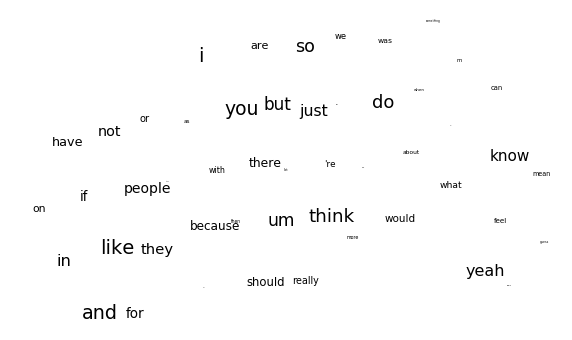

In [140]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

From the visualization above, we could see that ``you`` and ``I`` are close, ``should`` and ``really`` are close to each other. Some patterns of common expressions and part of speech are captured by the word embeddings.

Consider the relative poor performance of our model, we further import Model of ``Google 2013 Word2Vec``, to examine our corpora better:

In [12]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In the Google Word2Vec model, the closet words to 'agree' are 'disagree', 'concur','agrees', which are semantically related, compared to the 'on', 'just', 'like', the words closet to 'agree' in the word2vec model built by our corpora. 

In [51]:
model.most_similar('agree')

[('disagree', 0.7711759209632874),
 ('concur', 0.7131548523902893),
 ('agrees', 0.5929451584815979),
 ('disagreed', 0.5711543560028076),
 ('Agree', 0.5635050535202026),
 ('disagreeing', 0.5525435209274292),
 ('respectfully_disagree', 0.5464814901351929),
 ('agreed', 0.5445383787155151),
 ('insist', 0.5273953676223755),
 ('accept', 0.5188775658607483)]

In the google model, unexpectedly, the most distinct words are 'I' and then 'agree' in this sequence:

In [52]:
model.doesnt_match(['agree', 'appreciate', 'but', 'i', 'you','and','yeah','laugh'])

'i'

In [55]:
model.doesnt_match(['agree', 'appreciate', 'you','and','yeah'])

'agree'

And for the anaology calculation for 'i', 'agree', 'disagree' , the results of Google word embedding model is not ideal as well.

In [54]:
model.most_similar(positive=['i', 'agree'], negative = ['disagree'])

[('im', 0.5693854093551636),
 ('ive', 0.5568475723266602),
 ('lol', 0.552156925201416),
 ('i_cant', 0.547593355178833),
 (';)', 0.5446286201477051),
 ('alex', 0.544556736946106),
 (':-(', 0.5441746711730957),
 ('u', 0.5382288694381714),
 ('i_couldnt', 0.5372582077980042),
 ('haha', 0.5370227098464966)]

For the 'i' 'think', 'you' analogy calculation, the results are kind of interesting that the cloest words to 'you' in this expression is ``believe``: I think ~= You believe.

In [50]:
model.most_similar(positive=['i', 'think'], negative = ['you'])

[('belive', 0.565329372882843),
 ('beleive', 0.5597293376922607),
 ('Function_Lens', 0.5519909262657166),
 ('minerals_inc', 0.5394440293312073),
 ('again_replying_msg', 0.5377163887023926),
 ('thats', 0.526217520236969),
 ('love_veronica_Mars', 0.5247094631195068),
 ('imo', 0.5233933925628662),
 ('LOVE_YOU_ALL', 0.5208297967910767),
 ('i_realy', 0.5203044414520264)]

Now visualize the same 50 words in the word imbeddings we built mapped on the Google word2vec model:

In [57]:
numWords = 50
targetWords = conW2V.wv.index2word[:numWords]

In [58]:
wordsSubMatrix2 = []
targetWords2=[]
num_word=0
for word in targetWords:
    if word in model:
        num_word+=1
        wordsSubMatrix2.append(model[word])
        targetWords2.append(word)
wordsSubMatrix2 = np.array(wordsSubMatrix2)
wordsSubMatrix2

array([[-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       [ 0.10351562,  0.13769531, -0.00297546, ...,  0.04394531,
        -0.14550781,  0.07128906],
       [ 0.20410156,  0.01318359,  0.07568359, ..., -0.21191406,
        -0.1328125 ,  0.10839844],
       ...,
       [-0.07373047,  0.06030273,  0.10791016, ..., -0.16796875,
        -0.21972656, -0.00239563],
       [ 0.17871094,  0.09130859, -0.00165558, ...,  0.125     ,
         0.08056641,  0.01672363],
       [ 0.08251953, -0.15136719,  0.06591797, ..., -0.1015625 ,
        -0.10839844, -0.20507812]], dtype=float32)

In [62]:
pcaWords = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix2)
reducedPCA_data = pcaWords.transform(wordsSubMatrix2)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

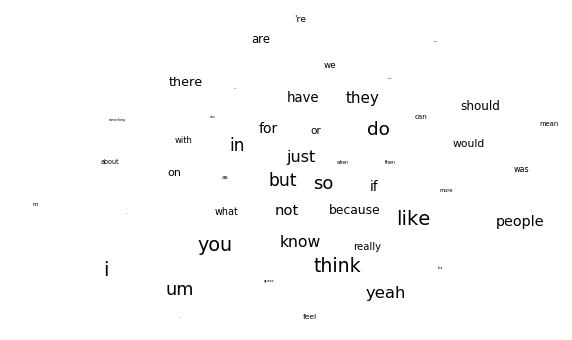

In [64]:
#visualization based on Google word2vec model
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords2):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Compare the visualization based on Google model (above) to the one we build (below),I found that actually the difference is not that significant, some pairs of words are kept together in both visualizations: for example, 1) 'I'-'you'; 2) 'do'-'just'-'so'; 3) 'in'-'on', which might because these words are naturally same and the relationship is coherent in whatever corpora. 

And to capture the natural relationship between words, the Google model actually outperforms, like, 'because','if','but' these conjunctions, are close together in the Google model, where relative far away in our model.

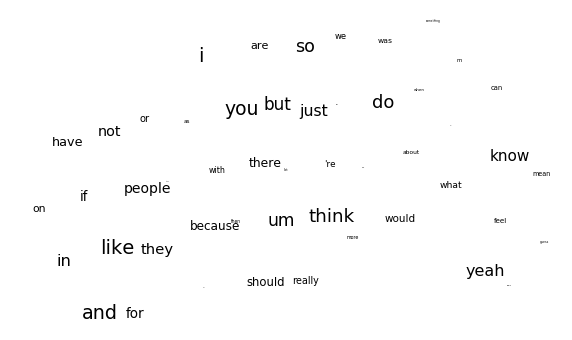

In [140]:
#visulization based on our Word2Vec model built on our corpora
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. 

and I will build the doc2vec model based on the 'document' of each turn of each subj in conversation, so each document will be the words the subj said in each turn. First of all, prepare the corpora and normalize the words:

In [66]:
df_AB_turn['normalized_words'] = df_AB_turn['tokenized_text'].apply(lambda x: normalizeTokens2(x, lemma=False))

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.
Considering there no keywords related to the corpora of each turn, we will only use unique label ('pairID_A/B_turnNo_TYB/NB') for each document (words of each turn) to build the Doc2vec model:

In [67]:
taggedDocs = []
df_AB_turn['new_label']='0'*len(df_AB_turn)
for index, row in df_AB_turn.iterrows():
    label_uniq=str(row['pair_id'])+'_'+row['agent']+'_'+str(row['round'])+'_'+row['condition']
    df_AB_turn.loc[index,['new_label']]=label_uniq
    docKeywords1=[label_uniq]
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords1))
df_AB_turn['Taggedtext'] = taggedDocs

In [68]:
docKeywords1

['62_B_7_TYB']


Now we can train a Doc2Vec model:

In [69]:
conD2V_turn = gensim.models.doc2vec.Doc2Vec(df_AB_turn['Taggedtext'], vector_size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [71]:
conD2V_turn.docvecs['62_B_7_TYB']

array([-0.00733396,  0.00265385,  0.01332101, -0.00394947,  0.00585291,
        0.00739648, -0.01859718,  0.00364841,  0.005267  , -0.00118988,
       -0.00076863, -0.00036931,  0.00054308,  0.00674716,  0.00239493,
        0.01221974,  0.01306304,  0.00087055,  0.00351242,  0.00379159,
        0.00040907, -0.00411439, -0.00021197, -0.00582541, -0.00145041,
       -0.00335665,  0.0045631 , -0.00728919,  0.0073352 ,  0.00508467,
        0.00646831,  0.00040594,  0.00787214,  0.00402727,  0.00256711,
        0.01339178, -0.00173642,  0.00467531,  0.00112179,  0.0024001 ,
        0.01129155, -0.00449768, -0.00020692,  0.00544315,  0.01482897,
        0.0062233 ,  0.0012919 ,  0.00617979,  0.00885284,  0.00744054,
        0.00808269, -0.00404853, -0.00159307,  0.00319396, -0.00975107,
       -0.00621729, -0.00179888,  0.00242112,  0.00176487,  0.0118301 ,
       -0.00244253,  0.00828959,  0.00937274,  0.00129134,  0.00431198,
        0.00557288,  0.00013871, -0.00105474,  0.00478154, -0.01

We can still use the most_similar command to perform simple semantic equations:

For the 'i'-'think','you' equation, the results are kind of interesting that 'should' is most connected with 'you'.

In [72]:
conD2V_turn.most_similar(positive = ['i','think'], negative = ['you'], topn = 1)

[('should', 0.9998600482940674)]

We can also compute all of these by hand--explicitly wth vector algebra: 

However, the cosine_similarity score is all very high, close to 1 for every pair of words, especially when compared with the Google Word2Vec model. The reasons might be the small corpora we have-small number of document, and relative small number of words in it. 

In [73]:
sklearn.metrics.pairwise.cosine_similarity(conD2V_turn['i'].reshape(1,-1), conD2V_turn['you'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.9999041]], dtype=float32)

In [76]:
sklearn.metrics.pairwise.cosine_similarity(conD2V_turn['think'].reshape(1,-1), conD2V_turn['like'].reshape(1,-1))

array([[0.999889]], dtype=float32)

Results of similarity based on our model (above), results of similarity based on Google Word2Vec model (below):

In [170]:
sklearn.metrics.pairwise.cosine_similarity(model['i'].reshape(1,-1), model['you'].reshape(1,-1))

array([[0.3817062]], dtype=float32)

In [75]:
sklearn.metrics.pairwise.cosine_similarity(model['think'].reshape(1,-1), model['like'].reshape(1,-1))

array([[0.5020043]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

Not very ideally, the 5 top most similar documents to 'appreciate' and 'agree' most come from 'NB' (No because) conditions, and all from Person A in the first several turns. However, considering the very same results (documents similar to the interested words) to both 'agree' and 'disagree', the capacity of the model to actually capture the semantic difference between corpora is questionable. 

In [77]:
conD2V_turn.docvecs.most_similar([ conD2V_turn['appreciate'] ], topn=5 )

[('61_A_3_NB', 0.9993526339530945),
 ('37_A_1_NB', 0.9993285536766052),
 ('33_A_3_NB', 0.9993213415145874),
 ('60_A_2_TYB', 0.9993174076080322),
 ('18_A_2_NB', 0.9992918968200684)]

In [78]:
conD2V_turn.docvecs.most_similar([ conD2V_turn['agree'] ], topn=5 )

[('33_A_3_NB', 0.9996695518493652),
 ('37_A_1_NB', 0.9995946884155273),
 ('23_A_1_NB', 0.9995752573013306),
 ('5_A_3_NB', 0.9995740652084351),
 ('61_A_3_NB', 0.9995501041412354)]

In [82]:
conD2V_turn.docvecs.most_similar([ conD2V_turn['disagree'] ], topn=5 )

[('33_A_3_NB', 0.9997240304946899),
 ('37_A_1_NB', 0.9995736479759216),
 ('61_A_3_NB', 0.9995533227920532),
 ('60_A_2_TYB', 0.9995445609092712),
 ('23_A_1_NB', 0.9995170831680298)]

Now let's go the other way around and find words most similar to this document:

The documents show up in all the three cells above-similar to all three words, which might be 'standard' document in the corpora: not suprisingly, the most similar words are just the most common expression words in a conversation, which further validate the guess that the Doc2vec model is not capable of capturing the nuanced semantic differences in the corpora.

In [83]:
conD2V_turn.most_similar( [conD2V_turn.docvecs['33_A_3_NB'] ], topn=5) 

[('are', 0.9997745156288147),
 ('from', 0.9997735023498535),
 ('would', 0.9997671246528625),
 ('person', 0.9997661113739014),
 ('more', 0.9997656345367432)]

In [84]:
conD2V_turn.most_similar( [conD2V_turn.docvecs['37_A_1_NB'] ], topn=5) 

[('all', 0.9997042417526245),
 ('like', 0.9996964931488037),
 ('umm', 0.9996815919876099),
 ('from', 0.9996705055236816),
 ('but', 0.9996683597564697)]

We can even look for documents most like a query composed of multiple words: results are not very promising as well.

In [86]:
conD2V_turn.docvecs.most_similar([ conD2V_turn['agree']+conD2V_turn['laugh']+conD2V_turn['yeah']], topn=5 )

[('33_A_3_NB', 0.9997162222862244),
 ('37_A_1_NB', 0.9996488094329834),
 ('23_A_1_NB', 0.9996388554573059),
 ('60_A_2_TYB', 0.9996167421340942),
 ('5_A_3_NB', 0.9996119737625122)]

Then, we further try with develop the doc2vec model with the dataframe of each subj and also the dataframe of each pair, which has few documents, but more words in each documents to see whether the length of documents will influence the model performance and the results or not.

Build Doc2Vec model based on each pair of conversation:

In [89]:
df_con2['tokenized_words'] = df_con2['conversation_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_con2['normalized_words'] = df_con2['tokenized_words'].apply(lambda x: normalizeTokens2(x, lemma=False))

In [91]:
taggedDocs = []
df_con2['new_label']='0'*len(df_con2)
for index, row in df_con2.iterrows():
    label_uniq=str(row['pair_id'])+'_'+row['condition']
    df_con2['new_label'][index]=label_uniq
    docKeywords2=[label_uniq]
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords2))
df_con2['Taggedtext'] = taggedDocs

In [92]:
conD2V = gensim.models.doc2vec.Doc2Vec(df_con2['Taggedtext'], vector_size = 100) #Limiting to 100 dimensions

Build Doc2Vec model based on each subj of conversation:

In [88]:
df_AB['tokenized_words'] = df_AB['con_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_AB['normalized_words'] = df_AB['tokenized_words'].apply(lambda x: normalizeTokens2(x, lemma=False))

In [90]:
taggedDocs = []
df_AB['new_label']='0'*len(df_AB)
for index, row in df_AB.iterrows():
    #docKeywords.append(row['topic']) #This lets us extract individual documnets since doi's are unique
    docKeywords0=[row['label']+'_'+row['condition']]
    df_AB['new_label'][index]=row['label']+'_'+row['condition']
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords0))
df_AB['Taggedtext'] = taggedDocs

In [93]:
conD2V_AB = gensim.models.doc2vec.Doc2Vec(df_AB['Taggedtext'], vector_size = 100) #Limiting to 100 dimensions

Try again the functions above with these two new doc2vec models.

For the equation building, the results are quite consistent among all three models:

In [96]:
conD2V.most_similar(positive = ['i','think'], negative = ['you'], topn = 1)

[('should', 0.9998527765274048)]

In [97]:
conD2V_AB.most_similar(positive = ['i','think'], negative = ['you'], topn = 1)

[('should', 0.999855637550354)]

In [98]:
conD2V_turn.most_similar(positive = ['i','think'], negative = ['you'], topn = 1)

[('should', 0.9998600482940674)]

To find the most similar documents based on a sequence of words: however the results are not very consistent among three models, only pair_22 appeared in the pair/subj models, which further shed light on the quality of the Doc2Vec models built by our corpora is relatively low.

In [100]:
conD2V.docvecs.most_similar([ conD2V['agree']+conD2V['laugh']+conD2V['yeah']], topn=5 )

[('61_NB', 0.9999276995658875),
 ('21_NB', 0.9999253749847412),
 ('27_TYB', 0.9999251961708069),
 ('22_TYB', 0.9999238848686218),
 ('28_NB', 0.9999189972877502)]

In [101]:
conD2V_AB.docvecs.most_similar([ conD2V_AB['agree']+conD2V_AB['laugh']+conD2V_AB['yeah']], topn=5 )

[('A_22_TYB', 0.9998900890350342),
 ('A_44_TYB', 0.9998828172683716),
 ('A_1_NB', 0.9998804926872253),
 ('A_45_NB', 0.9998512268066406),
 ('B_17_TYB', 0.9998488426208496)]

In [102]:
conD2V_turn.docvecs.most_similar([ conD2V_turn['agree']+conD2V_turn['laugh']+conD2V_turn['yeah']], topn=5 )

[('33_A_3_NB', 0.9997162222862244),
 ('37_A_1_NB', 0.9996488094329834),
 ('23_A_1_NB', 0.9996388554573059),
 ('60_A_2_TYB', 0.9996167421340942),
 ('5_A_3_NB', 0.9996119737625122)]

Now let's plot some words and documents against one another with a heatmap:

Similarity between first documents (pair) based Doc2Vec built on pair corpora:

In [187]:
targetDocs = df_con2['new_label'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = conD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, conD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

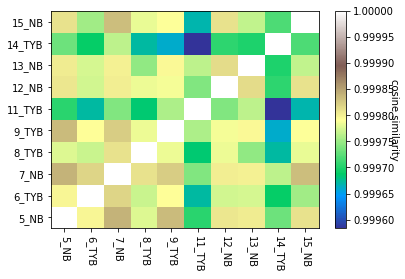

In [188]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Similarity between first documents (subj) based Doc2Vec built on subj corpora:

In [189]:
targetDocs = df_AB['new_label'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = conD2V_AB.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, conD2V_AB.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

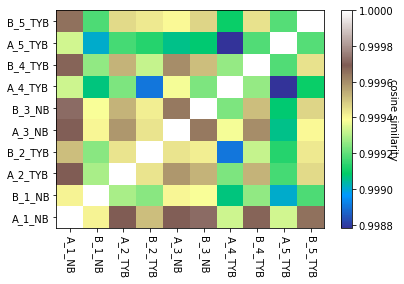

In [190]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

And we could further calculate the similarity between each pair, based on the subj model:

In [105]:
targetDocs = df_AB['new_label']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = conD2V_AB.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, conD2V_AB.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [106]:
#pair similarity
M=heatmapMatrixD
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(46):
    if df_AB['condition'][2*i]=='TYB':
        sim_pair_TYB.append(float(M[2*i,2*i+1]))
    if df_AB['condition'][2*i]=='NB':
        sim_pair_NB.append(float(M[2*i,2*i+1]))    

In [107]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg similarity of pair in TYB',round(avg_sim_pair_TYB,4))
print('Avg similarity of pair in NB',round(avg_sim_pair_NB,4))

Avg similarity of pair in TYB 0.9991
Avg similarity of pair in NB 0.9992


In [109]:
#averaged distance across all agents
print('Avg similarity of each two agent:',round(np.mean(M),4))

Avg similarity of each two agent: 0.9992


The result indicates pair in TYB condition is little bit less similar than pairs in NB condition according to the Doc2Vec model. However, the score is just preliminary, since the general unreliability of the Doc2Vec models built based on our corpora.

Similarity between first documents (turn) based Doc2Vec built on corpora of each turn:

In [191]:
targetDocs = df_AB_turn['new_label'][:10]  #if turn==1, ==2

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = conD2V_turn.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, conD2V_turn.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

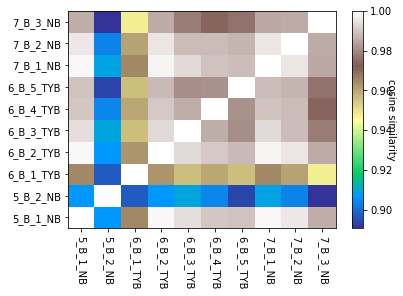

In [192]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

From the visualizaiton above, we could further see that compared with Doc2Vec model built on pair and subj corpora, the similarity between turn documents actually goes a little bit reasonably slower, which means more documents of distinctive feature might be able to better capture the difference between documents.

However, the general similarity score is still very high based on the Doc2Vec model built by our coproa, which is not ideal. Therefore, for further analysis, I try to manually calculate 'vectors for each document' based on the averaged vectors of all words in the document of interest according to the Google Word2Vec Model:

Calculate the doc vector based on the averaged word vectors (from Google Model) in each document:

In [112]:
def word2docvec(wordlist):
    doc_vec0=[model[x] for x in wordlist if x in model]
    doc_vec=sum(doc_vec0)/len(doc_vec0)
    return doc_vec

In [113]:
df_AB['doc_vec_g']=df_AB['normalized_words'].apply(lambda x: word2docvec(x))
df_con2['doc_vec_g']=df_con2['normalized_words'].apply(lambda x: word2docvec(x))
df_AB_turn['doc_vec_g']=df_AB_turn['normalized_words'].apply(lambda x: word2docvec(x))

Calculate Similarity between PersonA/B in each Pair:

In [114]:
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(46):
    condition=df_AB['condition'][2*i]
    A_vec=df_AB['doc_vec_g'][2*i].reshape(1, -1)
    B_vec=df_AB['doc_vec_g'][2*i+1].reshape(1, -1)
    AB_sim=sklearn.metrics.pairwise.cosine_similarity(A_vec,B_vec)
    if condition=='TYB':
        sim_pair_TYB.append(AB_sim)
    elif condition=='NB':
        sim_pair_NB.append(AB_sim)

In [115]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg similarity of pair in TYB',round(float(avg_sim_pair_TYB),4))
print('Avg similarity of pair in NB',round(float(avg_sim_pair_NB),4))

Avg similarity of pair in TYB 0.9606
Avg similarity of pair in NB 0.9543


From the doc vectors calculated by Google Word2Vec model, we could see that pairs in TYB is slightly more similar than pairs in NB condition (which kind of contradicts the results calculated by our model but more reliable)

Similarity of pairs change across time:

We are also interested in the similarity between pairs changed across time (First Turn, Second Turn, Thrid Turn, and Last Turn, Last second turn, and Last thrid Turn)

In [116]:
#define function to calcualte similarity score of a pair 
def docvec_pair_sim(df,pair,round_num_A,round_num_B):
    A1=df[(df['index']==pair) & (df['round']==round_num_A) & (df['agent']=='A')]['doc_vec_g']
    B1=df[(df['index']==pair) & (df['round']==round_num_B) & (df['agent']=='B')]['doc_vec_g']
    a1=[v for i,v in A1.items()]
    b1=[v for i,v in B1.items()]
    A1_vec=a1[0].reshape(1, -1)
    B1_vec=b1[0].reshape(1, -1)
    turn_sim=sklearn.metrics.pairwise.cosine_similarity(A1_vec,B1_vec)
    return turn_sim

In [125]:
# calculate similarity score of pairs in turn1,2,3
turn1_sim_TYB,turn1_sim_NB=[],[]
turn2_sim_TYB,turn2_sim_NB=[],[]
turn3_sim_TYB,turn3_sim_NB=[],[]
par_list=range(46)
par_list=[x for x in par_list if x not in [13,14,15,21]]   
#we remove the pairs which have weigh more turns due to different standards of transcription by RA
#long_pair=[5,8,9,13,14,15,18,19,21,23,26,32,39,43,45]
#par_list=[x for x in par_list if x not in long_pair]
for i in par_list:
    pair_id=df_con2['pair_id'][i]
    condition=df_con2['condition'][i]
    #turn1
    if 1 in df_con2['round_A'][i] and 1 in df_con2['round_B'][i]:
        turn_sim1=docvec_pair_sim(df_AB_turn,i,1,1)
        if condition=='TYB':
            turn1_sim_TYB.append(turn_sim1)
        elif condition=='NB':
            turn1_sim_NB.append(turn_sim1)
    #turn2
    if 2 in df_con2['round_A'][i] and 2 in df_con2['round_B'][i]:
        turn_sim2=docvec_pair_sim(df_AB_turn,i,2,2)
        if condition=='TYB':
            turn2_sim_TYB.append(turn_sim2)
        elif condition=='NB':
            turn2_sim_NB.append(turn_sim2)   
    #turn3
    if 3 in df_con2['round_A'][i] and 3 in df_con2['round_B'][i]:
        turn_sim3=docvec_pair_sim(df_AB_turn,i,3,3)
        if condition=='TYB':
            turn3_sim_TYB.append(turn_sim3)
        elif condition=='NB':
            turn3_sim_NB.append(turn_sim3)    

In [118]:
avg_sim_turn1_TYB=sum(turn1_sim_TYB)/len(turn1_sim_TYB)
avg_sim_turn1_NB=sum(turn1_sim_NB)/len(turn1_sim_NB)
print('Num of',len(turn1_sim_TYB)+len(turn1_sim_NB),'pairs: TYB:',len(turn1_sim_TYB),' NB:',len(turn1_sim_NB))
print('Avg similarity of pair in TYB turn1',round(float(avg_sim_turn1_TYB),4))
print('Avg similarity of pair in NB turn1',round(float(avg_sim_turn1_NB),4))

Num of 42 pairs: TYB: 22  NB: 20
Avg similarity of pair in TYB turn1 0.87
Avg similarity of pair in NB turn1 0.883


In [119]:
avg_sim_turn2_TYB=sum(turn2_sim_TYB)/len(turn2_sim_TYB)
avg_sim_turn2_NB=sum(turn2_sim_NB)/len(turn2_sim_NB)
print('Num of',len(turn2_sim_TYB)+len(turn2_sim_NB),'pairs: TYB:',len(turn2_sim_TYB),' NB:',len(turn2_sim_NB))
print('Avg similarity of pair in TYB turn2',round(float(avg_sim_turn2_TYB),4))
print('Avg similarity of pair in NB turn2',round(float(avg_sim_turn2_NB),4))

Num of 42 pairs: TYB: 22  NB: 20
Avg similarity of pair in TYB turn2 0.8829
Avg similarity of pair in NB turn2 0.864


In [120]:
avg_sim_turn3_TYB=sum(turn3_sim_TYB)/len(turn3_sim_TYB)
avg_sim_turn3_NB=sum(turn3_sim_NB)/len(turn3_sim_NB)
print('Num of',len(turn3_sim_TYB)+len(turn3_sim_NB),'pairs: TYB:',len(turn3_sim_TYB),' NB:',len(turn3_sim_NB))
print('Avg similarity of pair in TYB turn3',round(float(avg_sim_turn3_TYB),4))
print('Avg similarity of pair in NB turn3',round(float(avg_sim_turn3_NB),4))

Num of 31 pairs: TYB: 18  NB: 13
Avg similarity of pair in TYB turn3 0.841
Avg similarity of pair in NB turn3 0.8104


In [126]:
#last three turn
lturn1_sim_TYB=[]
lturn1_sim_NB=[]
lturn2_sim_TYB=[]
lturn2_sim_NB=[]
lturn3_sim_TYB=[]
lturn3_sim_NB=[]
par_list=range(46)
par_list=[x for x in par_list if x not in [13,14,15,21]]
#long_pair=[5,8,9,13,14,15,18,19,21,23,26,32,39,43,45]
#par_list=[x for x in par_list if x not in long_pair]
for i in par_list:
    pair_id=df_con2['pair_id'][i]
    condition=df_con2['condition'][i]
    round_A=df_con2['round_A'][i]
    round_B=df_con2['round_B'][i]
    lturn1_A=round_A[-1]
    lturn1_B=round_B[-1]
    lturn2_A=round_A[-2]
    lturn2_B=round_B[-2]
    if len(round_A)>=3 and len(round_B)>=3:
        lturn3_A=round_A[-3]
        lturn3_B=round_B[-3]
    else:
        lturn3_A=0
        lturn3_B=0
        
    #last turn1
    turn_sim1=docvec_pair_sim(df_AB_turn,i,lturn1_A,lturn1_B)
    if condition=='TYB':
        lturn1_sim_TYB.append(turn_sim1)
    elif condition=='NB':
        lturn1_sim_NB.append(turn_sim1)

    #last turn2
    turn_sim2=docvec_pair_sim(df_AB_turn,i,lturn2_A,lturn2_B)
    if condition=='TYB':
        lturn2_sim_TYB.append(turn_sim2)
    elif condition=='NB':
        lturn2_sim_NB.append(turn_sim2)
        
    #last_turn3
    if lturn3_A!=0 and lturn3_B!=0:
        turn_sim3=docvec_pair_sim(df_AB_turn,i,lturn3_A,lturn3_B)
        if condition=='TYB':
            lturn3_sim_TYB.append(turn_sim3)
        elif condition=='NB':
            lturn3_sim_NB.append(turn_sim3)          

In [122]:
avg_sim_lturn1_TYB=sum(lturn1_sim_TYB)/len(lturn1_sim_TYB)
avg_sim_lturn1_NB=sum(lturn1_sim_NB)/len(lturn1_sim_NB)
print('Num of',len(lturn1_sim_TYB)+len(lturn1_sim_NB),'pairs: TYB:',len(lturn1_sim_TYB),' NB:',len(lturn1_sim_NB))
print('Avg similarity of pair in TYB last turn1',round(float(avg_sim_lturn1_TYB),4))
print('Avg similarity of pair in NB last turn1',round(float(avg_sim_lturn1_NB),4))

Num of 31 pairs: TYB: 13  NB: 18
Avg similarity of pair in TYB last turn1 0.7806
Avg similarity of pair in NB last turn1 0.8224


In [123]:
avg_sim_lturn2_TYB=sum(lturn2_sim_TYB)/len(lturn2_sim_TYB)
avg_sim_lturn2_NB=sum(lturn2_sim_NB)/len(lturn2_sim_NB)
print('Num of',len(lturn2_sim_TYB)+len(lturn2_sim_NB),'pairs: TYB:',len(lturn2_sim_TYB),' NB:',len(lturn2_sim_NB))
print('Avg similarity of pair in TYB last turn2',round(float(avg_sim_lturn2_TYB),4))
print('Avg similarity of pair in NB last turn2',round(float(avg_sim_lturn2_NB),4))

Num of 31 pairs: TYB: 13  NB: 18
Avg similarity of pair in TYB last turn2 0.8751
Avg similarity of pair in NB last turn2 0.8544


In [124]:
avg_sim_lturn3_TYB=sum(lturn3_sim_TYB)/len(lturn3_sim_TYB)
avg_sim_lturn3_NB=sum(lturn3_sim_NB)/len(lturn3_sim_NB)
print('Num of',len(lturn3_sim_TYB)+len(lturn3_sim_NB),'pairs: TYB:',len(lturn3_sim_TYB),' NB:',len(lturn3_sim_NB))
print('Avg similarity of pair in TYB turn3',round(float(avg_sim_lturn3_TYB),4))
print('Avg similarity of pair in NB turn3',round(float(avg_sim_lturn3_NB),4))

Num of 20 pairs: TYB: 9  NB: 11
Avg similarity of pair in TYB turn3 0.8759
Avg similarity of pair in NB turn3 0.8519


Visualization: plot the change of similarity between pairs in each condition across turns.

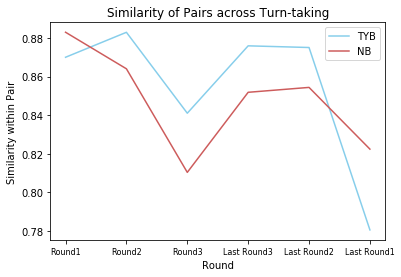

In [127]:
turn_TYB=[avg_sim_turn1_TYB,avg_sim_turn2_TYB,avg_sim_turn3_TYB,avg_sim_lturn3_TYB,avg_sim_lturn2_TYB,avg_sim_lturn1_TYB]
turn_NB=[avg_sim_turn1_NB,avg_sim_turn2_NB,avg_sim_turn3_NB,avg_sim_lturn3_NB,avg_sim_lturn2_NB,avg_sim_lturn1_NB]
turn_TYB=[float(x) for x in turn_TYB]
turn_NB=[float(x) for x in turn_NB]
label0=['Round1','Round2','Round3','Last Round3','Last Round2','Last Round1']
index=np.arange(len(label0))

plt.plot(index,turn_TYB,color='SkyBlue',label='TYB')
plt.plot(index,turn_NB,color='IndianRed',label='NB')

plt.xlabel('Round')
plt.ylabel('Similarity within Pair')
plt.xticks(index,label0,FontSize=8)
plt.legend()
plt.title('Similarity of Pairs across Turn-taking');

As we could see above, in TYB condition the similarity score in pair is at first relatively low, while after the first turn it soon changes to be higher at the second turn, which might be caused by our manipulation; and the relative high similarity continues till the end (last third and second turn) while experiences a drop at the last turn; while the NB condition shows opposite results.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

# Projection

We can also project word vectors to an arbitray semantic dimension. In this part homework, we try to find three dimensions: Affirmation, Agreement and Appreciation, based on the Google Word2Vec models, and project each pair/subj/turn vector of document on it.

In [128]:
#functions to develop dimensions
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

'Definition' of each dimension:

In [129]:
Affirmation = dimension(model, ['yes','do','okay','yeah'], ['no', 'don\'t', 'not','nope'])
Agreement = dimension(model, ['agree','admit','consent'], ['disagree','differ','dissent'])
Appreciation = dimension(model, ['appreciate','thank','grateful'], ['ingratitude','thankless','ungrateful'])

Functions to calculate similarity score based on these dimensions and doc vectors:

In [130]:
def simi_affirmation(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Affirmation.reshape(1,-1))[0][0]
    return simi
df_AB['doc_aff']=df_AB['doc_vec_g'].apply(lambda x: simi_affirmation(x))
df_AB_turn['doc_aff']=df_AB_turn['doc_vec_g'].apply(lambda x: simi_affirmation(x))

In [131]:
def simi_agreement(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Agreement.reshape(1,-1))[0][0]
    return simi
df_AB['doc_agg']=df_AB['doc_vec_g'].apply(lambda x: simi_agreement(x))
df_AB_turn['doc_agg']=df_AB_turn['doc_vec_g'].apply(lambda x: simi_agreement(x))

In [132]:
def simi_appreciation(docvec):
    simi=sklearn.metrics.pairwise.cosine_similarity(docvec.reshape(1,-1), Appreciation.reshape(1,-1))[0][0]
    return simi
df_AB['doc_app']=df_AB['doc_vec_g'].apply(lambda x: simi_appreciation(x))
df_AB_turn['doc_app']=df_AB_turn['doc_vec_g'].apply(lambda x: simi_appreciation(x))

##### Projection on dimension of PersonA/B in each condition

First of all, we try to examine the similarity in all PersonA and all Person B in each condition, to all three dimensions:

In [37]:
a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='A')]
aff_sim_A_TYB=list(a['doc_aff'])
avg_aff_sim_A_TYB=sum(aff_sim_A_TYB)/len(aff_sim_A_TYB)

a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='B')]
aff_sim_B_TYB=list(a['doc_aff'])
avg_aff_sim_B_TYB=sum(aff_sim_B_TYB)/len(aff_sim_B_TYB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='A')]
aff_sim_A_NB=list(a['doc_aff'])
avg_aff_sim_A_NB=sum(aff_sim_A_NB)/len(aff_sim_A_NB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='B')]
aff_sim_B_NB=list(a['doc_aff'])
avg_aff_sim_B_NB=sum(aff_sim_B_NB)/len(aff_sim_B_NB)

In [38]:
print('Avg similarity to Affirmation Dimension for A in TYB',round(avg_aff_sim_A_TYB,4))
print('Avg similarity to Affirmation Dimension for B in TYB',round(avg_aff_sim_B_TYB,4))
print('Avg similarity to Affirmation Dimension for A in NB',round(avg_aff_sim_A_NB,4))
print('Avg similarity to Affirmation Dimension for B in NB',round(avg_aff_sim_B_NB,4))

Avg similarity to Affirmation Dimension for A in TYB 0.3097
Avg similarity to Affirmation Dimension for B in TYB 0.3187
Avg similarity to Affirmation Dimension for A in NB 0.2889
Avg similarity to Affirmation Dimension for B in NB 0.2929


In [39]:
a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='A')]
sim_A_TYB=list(a['doc_agg'])
avg_agg_sim_A_TYB=sum(sim_A_TYB)/len(sim_A_TYB)

a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='B')]
sim_B_TYB=list(a['doc_agg'])
avg_agg_sim_B_TYB=sum(sim_B_TYB)/len(sim_B_TYB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='A')]
sim_A_NB=list(a['doc_agg'])
avg_agg_sim_A_NB=sum(sim_A_NB)/len(sim_A_NB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='B')]
sim_B_NB=list(a['doc_agg'])
avg_agg_sim_B_NB=sum(sim_B_NB)/len(sim_B_NB)

In [40]:
print('Avg similarity to Agreement Dimension for A in TYB',round(avg_agg_sim_A_TYB,4))
print('Avg similarity to Agreement Dimension for B in TYB',round(avg_agg_sim_B_TYB,4))
print('Avg similarity to Agreement Dimension for A in NB',round(avg_agg_sim_A_NB,4))
print('Avg similarity to Agreement Dimension for B in NB',round(avg_agg_sim_B_NB,4))

Avg similarity to Agreement Dimension for A in TYB 0.1449
Avg similarity to Agreement Dimension for B in TYB 0.1381
Avg similarity to Agreement Dimension for A in NB 0.1433
Avg similarity to Agreement Dimension for B in NB 0.1484


In [41]:
a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='A')]
sim_A_TYB=list(a['doc_app'])
avg_app_sim_A_TYB=sum(sim_A_TYB)/len(sim_A_TYB)

a=df_AB[(df_AB['condition']=='TYB') & (df_AB['agent']=='B')]
sim_B_TYB=list(a['doc_app'])
avg_app_sim_B_TYB=sum(sim_B_TYB)/len(sim_B_TYB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='A')]
sim_A_NB=list(a['doc_app'])
avg_app_sim_A_NB=sum(sim_A_NB)/len(sim_A_NB)

a=df_AB[(df_AB['condition']=='NB') & (df_AB['agent']=='B')]
sim_B_NB=list(a['doc_app'])
avg_app_sim_B_NB=sum(sim_B_NB)/len(sim_B_NB)

In [42]:
print('Avg similarity to Appreciation Dimension for A in TYB',round(avg_app_sim_A_TYB,4))
print('Avg similarity to Appreciation Dimension for B in TYB',round(avg_app_sim_B_TYB,4))
print('Avg similarity to Appreciation Dimension for A in NB',round(avg_app_sim_A_NB,4))
print('Avg similarity to Appreciation Dimension for B in NB',round(avg_app_sim_B_NB,4))

Avg similarity to Appreciation Dimension for A in TYB 0.0774
Avg similarity to Appreciation Dimension for B in TYB 0.0757
Avg similarity to Appreciation Dimension for A in NB 0.0744
Avg similarity to Appreciation Dimension for B in NB 0.0727


Visualization:

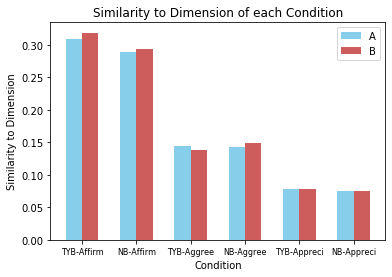

In [43]:
#Plot bar graph, with lines and std for LDA/QDA and each sample size
label0=['TYB-Affirm','NB-Affirm','TYB-Aggree','NB-Aggree','TYB-Appreci','NB-Appreci']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_aff_sim_A_TYB,avg_aff_sim_A_NB,avg_agg_sim_A_TYB,avg_agg_sim_A_NB,avg_app_sim_A_TYB,avg_app_sim_A_NB]
avg_B=[avg_aff_sim_B_TYB,avg_aff_sim_B_NB,avg_agg_sim_B_TYB,avg_agg_sim_B_NB,avg_app_sim_A_TYB,avg_app_sim_A_NB]

plt.bar(index,avg_A,width,color='SkyBlue',label='A') 
plt.bar(index+width,avg_B,width,color='IndianRed',label='B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width/2,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Dimension of each Condition');

As we could see above, generally the transcripts of all subjects have higher similarity to **Affirmation**, then **Agreement** and finally **Appreciation**. For **Affirmation**, subjs in TYB conditions have higher similarity to 'Affirmation' compared with NB condition, which is in line with our prediction. However, the similarity is even higher for Person B is kind of interesting, since Person B does not receive instructions at all. 

For **Aggreement** which is also against our prediciton, NB (No Because) condition shows higher similarity to agreement. The underlying reasons are needed to be further clarified. 

For **Appreciation** the similarity score is relative low and very close for each role and condition, which might because of the relatively low frequency of 'appreciate'/'thank' actually appeared in the corpora.

### Projection on dimension of across Time (*Turn*) in each condition

Then, we try to examine the similarity across **time/turn** to all three dimensionsin each condition:

**For Appreciation:**

In [133]:
#calculate similarity to Appreciation of each condition, for the first three turns
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1)]
sim_TYB=list(a['doc_app'])
avg_app_sim_1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2)]
sim_TYB=list(a['doc_app'])
avg_app_sim_2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3)]
sim_TYB=list(a['doc_app'])
avg_app_sim_3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)]
sim_NB=list(a['doc_app'])
avg_app_sim_1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)]
sim_NB=list(a['doc_app'])
avg_app_sim_2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)]
sim_NB=list(a['doc_app'])
avg_app_sim_3_NB=sum(sim_NB)/len(sim_NB)

In [134]:
print('Avg similarity to Appreciation Dimension for 1 in TYB',round(avg_app_sim_1_TYB,4))
print('Avg similarity to Appreciation Dimension for 2 in TYB',round(avg_app_sim_2_TYB,4))
print('Avg similarity to Appreciation Dimension for 3 in TYB',round(avg_app_sim_3_TYB,4))
print('Avg similarity to Appreciation Dimension for 1 in NB',round(avg_app_sim_1_NB,4))
print('Avg similarity to Appreciation Dimension for 2 in NB',round(avg_app_sim_2_NB,4))
print('Avg similarity to Appreciation Dimension for 3 in NB',round(avg_app_sim_3_NB,4))

Avg similarity to Appreciation Dimension for 1 in TYB 0.0841
Avg similarity to Appreciation Dimension for 2 in TYB 0.0707
Avg similarity to Appreciation Dimension for 3 in TYB 0.074
Avg similarity to Appreciation Dimension for 1 in NB 0.0732
Avg similarity to Appreciation Dimension for 2 in NB 0.0686
Avg similarity to Appreciation Dimension for 3 in NB 0.0603


Visualization:

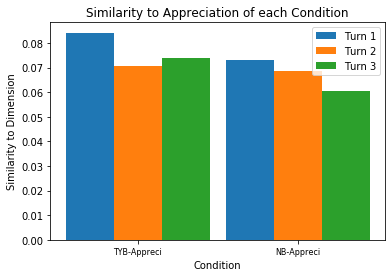

In [46]:
label0=['TYB-Appreci','NB-Appreci']
index=np.arange(len(label0))
width=0.3

avg_1=[avg_app_sim_1_TYB,avg_app_sim_1_NB]
avg_2=[avg_app_sim_2_TYB,avg_app_sim_2_NB]
avg_3=[avg_app_sim_3_TYB,avg_app_sim_3_NB]

plt.bar(index,avg_1,width,label='Turn 1') 
plt.bar(index+width,avg_2,width,label='Turn 2')
plt.bar(index+width+width,avg_3,width,label='Turn 3')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Appreciation of each Condition');

From the visualization above, we could clearly see that copora in TYB condition shower high 'appreciation', especially in the first Turn, which might be caused by our experiment manipulation; however, in NB condition, the appreciation score is not only low at the begining, but also drops gradually through the conversaion happening. 

Then we could take a deeper look at the role of each agent in the conversation: Person(A/B)

In [157]:
#Then, we could take a deeper look at the role of each subj-Person A and B
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_app'])
avg_app_sim_A1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_app'])
avg_app_sim_B1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_app'])
avg_app_sim_A2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_app'])
avg_app_sim_B2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_app'])
avg_app_sim_A3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_app'])
avg_app_sim_B3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_app'])
avg_app_sim_A1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_app'])
avg_app_sim_B1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_app'])
avg_app_sim_A2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_app'])
avg_app_sim_B2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_app'])
avg_app_sim_A3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_app'])
avg_app_sim_B3_NB=sum(sim_NB)/len(sim_NB)

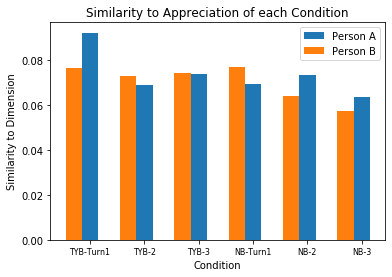

In [158]:
label0=['TYB-Turn1','TYB-2','TYB-3','NB-Turn1','NB-2','NB-3']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_app_sim_A1_TYB,avg_app_sim_A2_TYB,avg_app_sim_A3_TYB,avg_app_sim_A1_NB,avg_app_sim_A2_NB,avg_app_sim_A3_NB]
avg_B=[avg_app_sim_B1_TYB,avg_app_sim_B2_TYB,avg_app_sim_B3_TYB,avg_app_sim_B1_NB,avg_app_sim_B2_NB,avg_app_sim_B3_NB]

plt.bar(index+width,avg_A,width,label='Person A') 
plt.bar(index,avg_B,width,label='Person B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Appreciation of each Condition');

Not suprisingly, the relative high appreciation score in TYB condition--first run is contributed by Person A, who received the manipulation, however it goes down to normal level after the first run and seems not influence the appreciation level of Person B in the next run.

For NB condition, the relative low appreciation score in first run is also contributed by Person A who recieves instruction to negate; and very interesting, the 'appreciation' level of Person B goes down obviously and gradually after receiving negation from Person A. 

Then, we could also examine the similarity to appreciation dimension of the **last three runs**:

In [169]:
#Then, for the last three turn
lturn1_sim_TYB,lturn1_sim_NB,lturn1_sim_A_TYB,lturn1_sim_A_NB,lturn1_sim_B_TYB,lturn1_sim_B_NB=[],[],[],[],[],[]
lturn2_sim_TYB,lturn2_sim_NB,lturn2_sim_A_TYB,lturn2_sim_A_NB,lturn2_sim_B_TYB,lturn2_sim_B_NB=[],[],[],[],[],[]
lturn3_sim_TYB,lturn3_sim_NB,lturn3_sim_A_TYB,lturn3_sim_A_NB,lturn3_sim_B_TYB,lturn3_sim_B_NB=[],[],[],[],[],[]
par_list=range(46)
par_list=[x for x in par_list if x not in [13,14,15,21]]
#long_pair=[5,8,9,13,14,15,18,19,21,23,26,32,39,43,45]
#par_list=[x for x in par_list if x not in long_pair]
for i in par_list:
    pair_id=df_con2['pair_id'][i]
    condition=df_con2['condition'][i]
    round_A=df_con2['round_A'][i]
    round_B=df_con2['round_B'][i]
    lturn1_A=round_A[-1]
    lturn1_B=round_B[-1]
    lturn2_A=round_A[-2]
    lturn2_B=round_B[-2]
    if len(round_A)>=3 and len(round_B)>=3:
        lturn3_A=round_A[-3]
        lturn3_B=round_B[-3]
    else:
        lturn3_A=0
        lturn3_B=0
        
    #last turn1
    A1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn1_A) & (df_AB_turn['agent']=='A')]['doc_app']
    B1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn1_B) & (df_AB_turn['agent']=='B')]['doc_app'] 
    a1=[v for i,v in A1.items()]
    b1=[v for i,v in B1.items()] 
    lturn_sim1=(a1[0]+b1[0])/2
    if condition=='TYB':
        lturn1_sim_TYB.append(lturn_sim1)
        lturn1_sim_A_TYB.append(a1[0])
        lturn1_sim_B_TYB.append(b1[0])  
    elif condition=='NB':
        lturn1_sim_NB.append(lturn_sim1)
        lturn1_sim_A_NB.append(a1[0])
        lturn1_sim_B_NB.append(b1[0]) 

    #last turn2
    A1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn2_A) & (df_AB_turn['agent']=='A')]['doc_app']
    B1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn2_B) & (df_AB_turn['agent']=='B')]['doc_app'] 
    a1=[v for i,v in A1.items()]
    b1=[v for i,v in B1.items()] 
    lturn_sim1=(a1[0]+b1[0])/2
    if condition=='TYB':
        lturn2_sim_TYB.append(lturn_sim1)
        lturn2_sim_A_TYB.append(a1[0])
        lturn2_sim_B_TYB.append(b1[0])  
    elif condition=='NB':
        lturn2_sim_NB.append(lturn_sim1)
        lturn2_sim_A_NB.append(a1[0])
        lturn2_sim_B_NB.append(b1[0])
        
    #last turn3
    if lturn3_A!=0 and lturn3_B!=0:
        A1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn3_A) & (df_AB_turn['agent']=='A')]['doc_app']
        B1=df_AB_turn[(df_AB_turn['index']==i) & (df_AB_turn['round']==lturn3_B) & (df_AB_turn['agent']=='B')]['doc_app'] 
        a1=[v for i,v in A1.items()]
        b1=[v for i,v in B1.items()] 
        lturn_sim1=(a1[0]+b1[0])/2
        if condition=='TYB':
            lturn3_sim_TYB.append(lturn_sim1)
            lturn3_sim_A_TYB.append(a1[0])
            lturn3_sim_B_TYB.append(b1[0])  
        elif condition=='NB':
            lturn3_sim_NB.append(lturn_sim1)
            lturn3_sim_A_NB.append(a1[0])
            lturn3_sim_B_NB.append(b1[0])       

In [146]:
def list_mean(list0):
    nplist=np.array(list0)
    return np.mean(nplist)

In [170]:
avg_lturn1_sim_TYB=list_mean(lturn1_sim_TYB)
avg_lturn1_sim_NB=list_mean(lturn1_sim_NB)
avg_lturn1_sim_A_TYB=list_mean(lturn1_sim_A_TYB)
avg_lturn1_sim_A_NB=list_mean(lturn1_sim_A_NB)
avg_lturn1_sim_B_TYB=list_mean(lturn1_sim_B_TYB)
avg_lturn1_sim_B_NB=list_mean(lturn1_sim_B_NB)

avg_lturn2_sim_TYB=list_mean(lturn2_sim_TYB)
avg_lturn2_sim_NB=list_mean(lturn2_sim_NB)
avg_lturn2_sim_A_TYB=list_mean(lturn2_sim_A_TYB)
avg_lturn2_sim_A_NB=list_mean(lturn2_sim_A_NB)
avg_lturn2_sim_B_TYB=list_mean(lturn2_sim_B_TYB)
avg_lturn2_sim_B_NB=list_mean(lturn2_sim_B_NB)

avg_lturn3_sim_TYB=list_mean(lturn3_sim_TYB)
avg_lturn3_sim_NB=list_mean(lturn3_sim_NB)
avg_lturn3_sim_A_TYB=list_mean(lturn3_sim_A_TYB)
avg_lturn3_sim_A_NB=list_mean(lturn3_sim_A_NB)
avg_lturn3_sim_B_TYB=list_mean(lturn3_sim_B_TYB)
avg_lturn3_sim_B_NB=list_mean(lturn3_sim_B_NB)

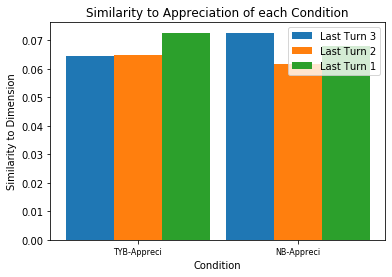

In [173]:
label0=['TYB-Appreci','NB-Appreci']
index=np.arange(len(label0))
width=0.3

avg_1=[avg_lturn1_sim_TYB,avg_lturn1_sim_NB]
avg_2=[avg_lturn2_sim_TYB,avg_lturn2_sim_NB]
avg_3=[avg_lturn3_sim_TYB,avg_lturn3_sim_NB]

plt.bar(index,avg_3,width,label='Last Turn 3') 
plt.bar(index+width,avg_2,width,label='Last Turn 2')
plt.bar(index+width+width,avg_1,width,label='Last Turn 1')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Appreciation of each Condition');

As shown in the above visualizaiton, in TYB condition-the last turn, the appreciation score boosts-*might actually be a compensation strategy of Person A to finally follow the instruction to express appreciaiton?*; while for NB condition, the appreciation level drops at the last second run and recovers a little bit at the final run.

Then we did visualization taking each agent **(PersonA/B)** into account:

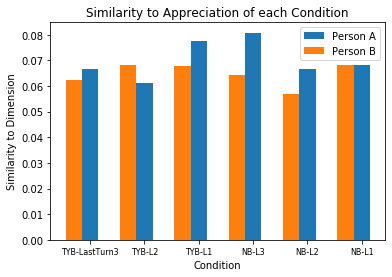

In [172]:
label0=['TYB-LastTurn3','TYB-L2','TYB-L1','NB-L3','NB-L2','NB-L1']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_lturn3_sim_A_TYB,avg_lturn2_sim_A_TYB,avg_lturn1_sim_A_TYB,avg_lturn3_sim_A_NB,avg_lturn2_sim_A_NB,avg_lturn1_sim_A_NB]
avg_B=[avg_lturn3_sim_B_TYB,avg_lturn2_sim_B_TYB,avg_lturn1_sim_B_TYB,avg_lturn3_sim_B_NB,avg_lturn2_sim_B_NB,avg_lturn1_sim_B_NB]

plt.bar(index+width,avg_A,width,label='Person A') 
plt.bar(index,avg_B,width,label='Person B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Appreciation of each Condition');

With the visualizaiton at agent level, we could more clearly see that the boost of appreciation of at the last run in TYB condition actually comes from Person A who receives the instruction, while the level of appreciaiton of Person B almost in TYB condition remains the same level. The final boost in TYB might actually is a result of reminding and finally executing the 'appreciaiton scripts' instructed at the begining. 

**For Affirmation:**

First of all, examine the similarity of conversation to Affirmation of the first three turns:

In [141]:
#calculate similarity to Aggreement of each condition, for the first three turns
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1)]
sim_TYB=list(a['doc_aff'])
avg_aff_sim_1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2)]
sim_TYB=list(a['doc_aff'])
avg_aff_sim_2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3)]
sim_TYB=list(a['doc_aff'])
avg_aff_sim_3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)]
sim_NB=list(a['doc_aff'])
avg_aff_sim_1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)]
sim_NB=list(a['doc_aff'])
avg_aff_sim_2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)]
sim_NB=list(a['doc_aff'])
avg_aff_sim_3_NB=sum(sim_NB)/len(sim_NB)

In [142]:
print('Avg similarity to Affirmation Dimension for 1 in TYB',round(avg_aff_sim_1_TYB,4))
print('Avg similarity to Affirmation Dimension for 2 in TYB',round(avg_aff_sim_2_TYB,4))
print('Avg similarity to Affirmation Dimension for 3 in TYB',round(avg_aff_sim_3_TYB,4))
print('Avg similarity to Affirmation Dimension for 1 in NB',round(avg_aff_sim_1_NB,4))
print('Avg similarity to Affirmation Dimension for 2 in NB',round(avg_aff_sim_2_NB,4))
print('Avg similarity to Affirmation Dimension for 3 in NB',round(avg_aff_sim_3_NB,4))

Avg similarity to Affirmation Dimension for 1 in TYB 0.2996
Avg similarity to Affirmation Dimension for 2 in TYB 0.297
Avg similarity to Affirmation Dimension for 3 in TYB 0.2972
Avg similarity to Affirmation Dimension for 1 in NB 0.2725
Avg similarity to Affirmation Dimension for 2 in NB 0.2689
Avg similarity to Affirmation Dimension for 3 in NB 0.2714


Visualization:

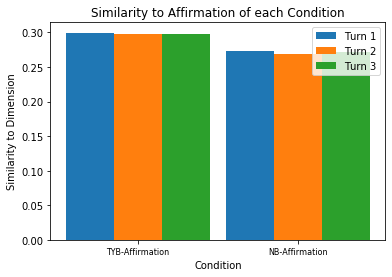

In [144]:
label0=['TYB-Affirmation','NB-Affirmation']
index=np.arange(len(label0))
width=0.3

avg_1=[avg_aff_sim_1_TYB,avg_aff_sim_1_NB]
avg_2=[avg_aff_sim_2_TYB,avg_aff_sim_2_NB]
avg_3=[avg_aff_sim_3_TYB,avg_aff_sim_3_NB]

plt.bar(index,avg_1,width,label='Turn 1') 
plt.bar(index+width,avg_2,width,label='Turn 2')
plt.bar(index+width+width,avg_3,width,label='Turn 3')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Affirmation of each Condition');

According to our expectation, in TYB condition, the level of 'affirmation' is generally high compared with NB condition; moreover, the level of 'affirmation' almost keeps the same in the first three run, while in NB condition, it drops gradually.

Then, we take a deeper look at the level of 'affirmation' of each agent (PersonA/B):

In [216]:
#Then, we could take a deeper look at the role of each subj-Person A and B
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_A1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_B1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_A2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_B2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_A3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_B3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==4) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_A4_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==4) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_aff'])
avg_app_sim_B4_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_aff'])
avg_app_sim_A1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_aff'])
avg_app_sim_B1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_aff'])
avg_app_sim_A2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_app'])
avg_app_sim_B2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_aff'])
avg_app_sim_A3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_aff'])
avg_app_sim_B3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==4)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_aff'])
avg_app_sim_A4_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==4)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_aff'])
avg_app_sim_B4_NB=sum(sim_NB)/len(sim_NB)

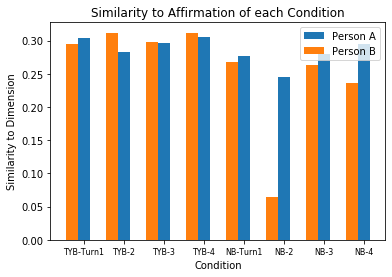

In [217]:
label0=['TYB-Turn1','TYB-2','TYB-3','TYB-4','NB-Turn1','NB-2','NB-3','NB-4']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_app_sim_A1_TYB,avg_app_sim_A2_TYB,avg_app_sim_A3_TYB,avg_app_sim_A4_TYB,avg_app_sim_A1_NB,avg_app_sim_A2_NB,avg_app_sim_A3_NB,avg_app_sim_A4_NB]
avg_B=[avg_app_sim_B1_TYB,avg_app_sim_B2_TYB,avg_app_sim_B3_TYB,avg_app_sim_B4_TYB,avg_app_sim_B1_NB,avg_app_sim_B2_NB,avg_app_sim_B3_NB,avg_app_sim_B4_NB]

plt.bar(index+width,avg_A,width,label='Person A') 
plt.bar(index,avg_B,width,label='Person B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Affirmation of each Condition');

Examing the level of 'affirmation' of each agent, we could see that in TYB condiiton, there seems a positive feedback loop that the slightly higher level of 'affirmation' of Person A in first run increases the level of 'affirmation' of Person B in the second turn, and finally reach a relative stable high level at the 3rd and 4th run. 

However, in NB condition, there is an obvious negative feedback in the first two turns (*the negation of Person A as instructed in the first turn significantly decreases the level of affirmation of Person B in the second turn, which is very interesting*), and then gradualy returns to higher affirmation level mainly driven by Person A who might want to compensate the negative influence at the begining of the conversation? 

**For Aggreement:**

Finally, examine how the level of 'aggrement' changes across time in each condition:

In [221]:
#calculate similarity to Aggreement of each condition, for the first three turns
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1)]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2)]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3)]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==4)]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_4_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)]
sim_NB=list(a['doc_agg'])
avg_agg_sim_1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)]
sim_NB=list(a['doc_agg'])
avg_agg_sim_2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)]
sim_NB=list(a['doc_agg'])
avg_agg_sim_3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==4)]
sim_NB=list(a['doc_agg'])
avg_agg_sim_4_NB=sum(sim_NB)/len(sim_NB)

Visualization:

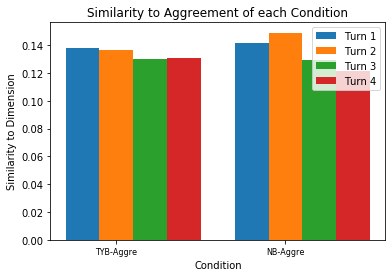

In [223]:
label0=['TYB-Aggre','NB-Aggre']
index=np.arange(len(label0))
width=0.2

avg_1=[avg_agg_sim_1_TYB,avg_agg_sim_1_NB]
avg_2=[avg_agg_sim_2_TYB,avg_agg_sim_2_NB]
avg_3=[avg_agg_sim_3_TYB,avg_agg_sim_3_NB]
avg_4=[avg_agg_sim_4_TYB,avg_agg_sim_4_NB]

plt.bar(index,avg_1,width,label='Turn 1') 
plt.bar(index+width,avg_2,width,label='Turn 2')
plt.bar(index+width+width,avg_3,width,label='Turn 3')
plt.bar(index+width+width+width,avg_4,width,label='Turn 4')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Aggreement of each Condition');

As we could see above, at the beginning of the conversation-the first two turn, the level of 'aggreement' is relativly high in NB condition compared with TYB condition; however, as turns going, **the level of 'agreement' drops greatly at the 3rd and 4th turns in NB condition**, while in TYB condition, 'agreement' level remains at a relative higher level.

Then take a deeper look at the contribution of each agent in the conversation across time:

In [224]:
#Then, we could take a deeper look at the role of each subj-Person A and B
a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_A1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==1) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_B1_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_A2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==2) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_B2_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_A3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==3) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_B3_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==4) & (df_AB_turn['agent']=='A')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_A4_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='TYB') & (df_AB_turn['round']==4) & (df_AB_turn['agent']=='B')]
sim_TYB=list(a['doc_agg'])
avg_agg_sim_B4_TYB=sum(sim_TYB)/len(sim_TYB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_A1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==1)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_B1_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_A2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==2)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_app'])
avg_agg_sim_B2_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_A3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==3)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_B3_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==4)& (df_AB_turn['agent']=='A')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_A4_NB=sum(sim_NB)/len(sim_NB)

a=df_AB_turn[(df_AB_turn['condition']=='NB') & (df_AB_turn['round']==4)& (df_AB_turn['agent']=='B')]
sim_NB=list(a['doc_agg'])
avg_agg_sim_B4_NB=sum(sim_NB)/len(sim_NB)

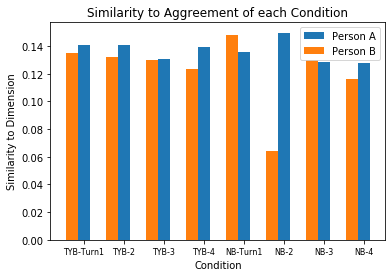

In [225]:
label0=['TYB-Turn1','TYB-2','TYB-3','TYB-4','NB-Turn1','NB-2','NB-3','NB-4']
index=np.arange(len(label0))
width=0.3

avg_A=[avg_agg_sim_A1_TYB,avg_agg_sim_A2_TYB,avg_agg_sim_A3_TYB,avg_agg_sim_A4_TYB,avg_agg_sim_A1_NB,avg_agg_sim_A2_NB,avg_agg_sim_A3_NB,avg_agg_sim_A4_NB]
avg_B=[avg_agg_sim_B1_TYB,avg_agg_sim_B2_TYB,avg_agg_sim_B3_TYB,avg_agg_sim_B4_TYB,avg_agg_sim_B1_NB,avg_agg_sim_B2_NB,avg_agg_sim_B3_NB,avg_agg_sim_B4_NB]

plt.bar(index+width,avg_A,width,label='Person A') 
plt.bar(index,avg_B,width,label='Person B')

plt.xlabel('Condition')
plt.ylabel('Similarity to Dimension')
plt.xticks(index+width,label0,FontSize=8)
plt.legend()
plt.title('Similarity to Aggreement of each Condition');

From the agent level, very interesting, we could also see a **'dramatic drop'** of 'agreement' level of Person B in NB condition, after receiving 'negation' from Person A at the first run. Then while the level of agreement of Person B gradually goes up to a higher level, however, following the instruction, the level of aggreement of Person A still remains relatively low at the 3rd and 4th rounds and at the same time further influnces the aggreement level of Person B.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

Because some erros in loading the COHA corpora, for this part of analysis, I try to compare the difference of **three embeddings built on our corpora of different level (pair/subj/turn)**; while they all come from the same transcription, each dataframe has different number of documents and different lengths of words of each document, and we want to see whether the word embedding models built on these different levels of data structure would be different or not.

Import and define necessary functions to compare embeddings:

In [231]:
import copy
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [191]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [192]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Build different word embedding models based on different data structure of our corpora (pair-built at the first exercise/subj/turn):

In [232]:
#build word embedding models based on turn corpora:
df_AB_turn['tokenized_sents'] = df_AB_turn['turn_txt'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_AB_turn['normalized_sents'] = df_AB_turn['tokenized_sents'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
conW2V_turn = gensim.models.word2vec.Word2Vec(df_AB_turn['normalized_sents'].sum())

In [230]:
#build word embedding models based on agent corpora:
df_AB['tokenized_sents'] = df_AB['con_txt'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_AB['normalized_sents'] = df_AB['tokenized_sents'].apply(lambda x: [normalizeTokens2(s, lemma=False) for s in x])
conW2V_AB = gensim.models.word2vec.Word2Vec(df_AB['normalized_sents'].sum())

Organize the three embedding models into one dataframe:

In [233]:
label_con=['con','con_AB','con_AB_turn']
con_df_w2v={'con':conW2V,'con_AB':conW2V_AB,'con_AB_turn':conW2V_turn}

Align the three embedding models: 

In [234]:
cats=label_con
embeddings_raw=con_df_w2v

embeddings_aligned = {}
for catOuter in cats:
    embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
    for catInner in cats:
        embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))

In [235]:
comparedEmbeddings=embeddings_aligned

In [236]:
comparedEmbeddings.keys()

dict_keys(['con', 'con_AB', 'con_AB_turn'])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [193]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words: 

we could see that the words in different models are very similar, with at most 0.0000060 divergence score; moreover, the turn word embedding model is extremely similar to the subj/agent one, while the pair one (which has the least document, but largest lenghth of each document) is slightly more different from these two models. 

like


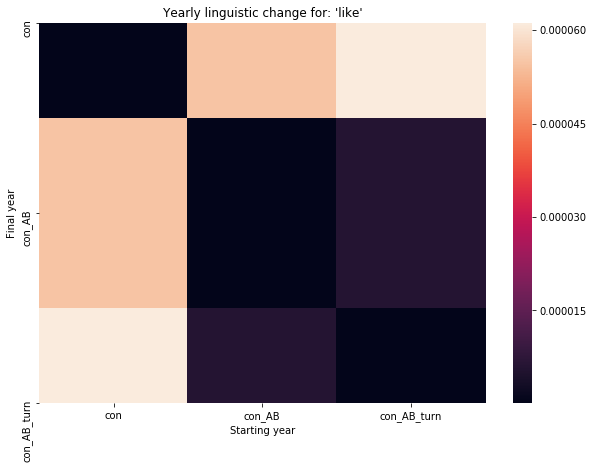

In [237]:
targetWord = 'like'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

i


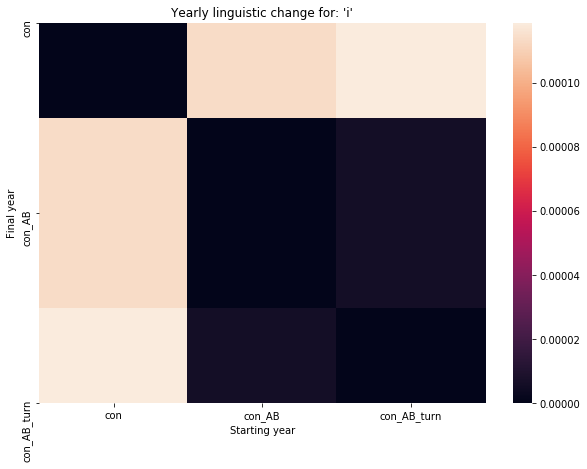

In [238]:
targetWord = 'i'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

Then, try to find the most divergent words:

In [201]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [202]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 454 words to compare


The most divergent words are:

It seems that the most divergent words are those appear less frequently in the corpora; while the divergence is relative small of these words between models, with the highest divergent score of 0.02.

In [203]:
wordDivergences[:20]

[('interesting', 0.019456863403320312),
 ('cause', 0.009976446628570557),
 ('last', 0.008586525917053223),
 ('i-', 0.00857996940612793),
 ('execution', 0.008251190185546875),
 ('exactly', 0.008161962032318115),
 ('helpful', 0.007470607757568359),
 ('situation', 0.007463216781616211),
 ('ok', 0.007367491722106934),
 ('super', 0.007281303405761719),
 ('ya', 0.005879759788513184),
 ('hate', 0.00520777702331543),
 ('abolished', 0.005060970783233643),
 ('remember', 0.004886806011199951),
 ('general', 0.004605591297149658),
 ('says', 0.004595935344696045),
 ('sorry', 0.0045716166496276855),
 ('working', 0.004559516906738281),
 ('sight', 0.004491686820983887),
 ('topic', 0.004229307174682617)]

And for the most divergent word-'Interesting' among models, the difference mainly lies in the *pair word embedding model* and the *turn model*, which is reasonalbe since that these two models are at the extreme places of all three models interms of document lengths and document numbers.

interesting


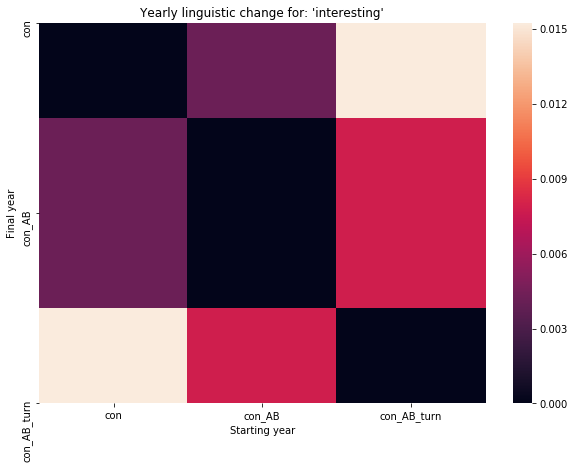

In [205]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

And for the least divergent words: all the common words in conversation are quite similar in all three models and nearly identical with divergence score close to zero.

In [204]:
wordDivergences[-20:]

[('uh', 8.279085159301758e-05),
 ('their', 8.243322372436523e-05),
 ('so', 8.124113082885742e-05),
 ('even', 8.016824722290039e-05),
 ('um', 7.802248001098633e-05),
 ('for', 7.593631744384766e-05),
 ('with', 7.277727127075195e-05),
 ('and', 7.05718994140625e-05),
 ('because', 6.99758529663086e-05),
 ('should', 6.878376007080078e-05),
 ('like', 6.788969039916992e-05),
 ('people', 6.657838821411133e-05),
 ('up', 6.085634231567383e-05),
 ('in', 5.996227264404297e-05),
 ('if', 5.829334259033203e-05),
 ('not', 5.811452865600586e-05),
 ('they', 5.751848220825195e-05),
 ('or', 5.549192428588867e-05),
 ('on', 4.965066909790039e-05),
 ('have', 4.8279762268066406e-05)]

have


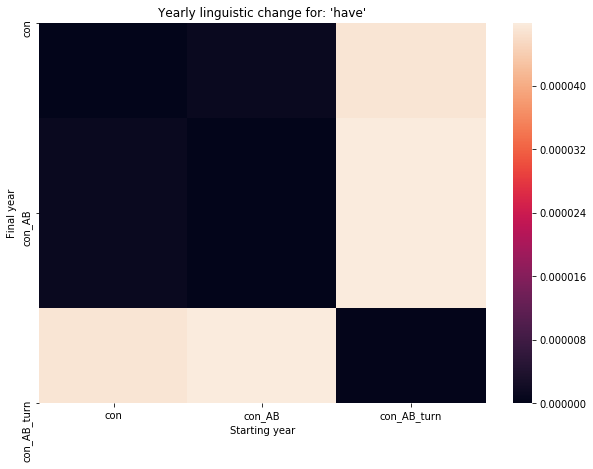

In [206]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()